In [2]:
##################################################
######### Method: SLR + LSTM Hybrid  #############
##################################################
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from netCDF4 import Dataset
from functionsLSTM_hybrid import *
from scipy import fftpack
from datetime import datetime
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
# np.random.seed(42)

num_cores = multiprocessing.cpu_count()
print('Number of cores:',num_cores)

# Define other parameters of the problem
n_pc = 150         # number of PCs
n_record = 50000   # total records
n_maxtrain = 40000 # maximum possible length of training data
n_test = n_record - n_maxtrain # length of the test data
test0_idx = n_maxtrain              # test data start index
dt = 10            # temporal resolution

#### Load the pcs ####
f = 'psi1_DG_0_500K_100days_filtered_150PCs.dat'
fpath = os.getcwd() + '/../' + f
pcs = dlmread(fpath,n_record,n_pc)
pcs = center(pcs)
# get the test dataset
test_data = pcs[test0_idx:test0_idx+n_test, :]
 
#### Load the EOFs ####
nx = 513; ny=513
eoffile = os.getcwd() + '/../psi1_DG_0_500K_100days_filtered_150EOFs.nc'
fid = Dataset(eoffile,'r')
eofs = fid.variables['EOFs'][:n_pc,:,:]
eofs = eofs.reshape((n_pc, nx*ny))

Using TensorFlow backend.


Number of cores: 24


In [5]:
# train the LR
n_train = n_maxtrain # Length used for training
[x_train, y_train, scaler_x] = training4tendency(pcs, n_pc, n_train, dt, 'standard_top_pc')

# Train the LR
start = datetime.now()
[linregmodel, linregres, r2_sco] = linear_regression(x_train,y_train)
print('LR training time:',datetime.now()-start)

LR training time: 0:00:00.609448


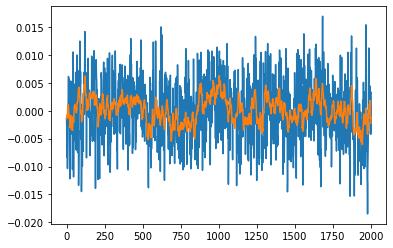

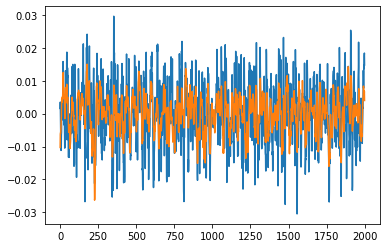

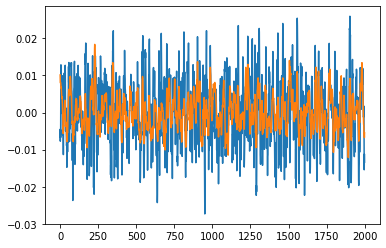

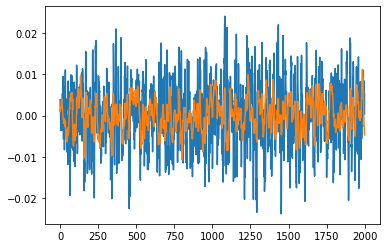

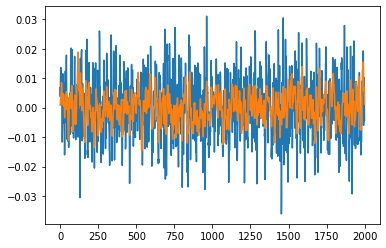

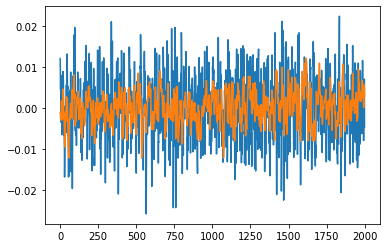

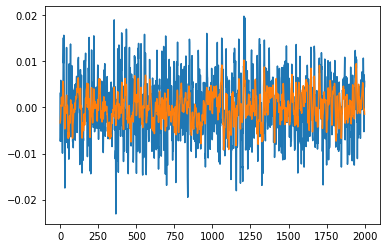

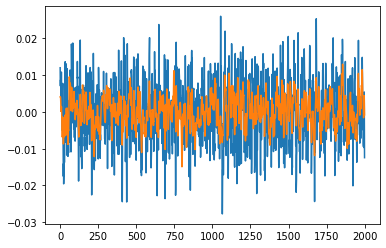

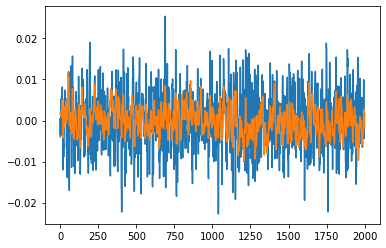

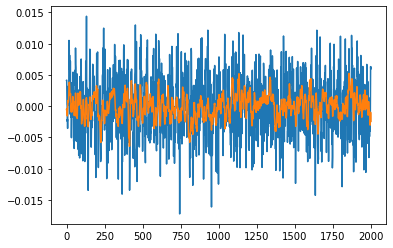

In [6]:
# plot LR output vs the truth
y_tend_LR = linregmodel.predict(x_train)
for k in range(10):
    plt.plot(y_train[:2000,k])
    plt.plot(y_tend_LR[:2000,k])
    plt.show()

In [7]:
# normalize the linear regression residuals
scaler_linregres = StandardScaler()
scaler_linregres.fit(np.tile(linregres[:,0].reshape(-1,1),(1, n_pc)))
linregresN = scaler_linregres.transform(linregres)

In [8]:
# Define the LSTM inputs/outputs and reshape x_train to [samples, time_steps, features]
x_train_lstm = []
y_train_lstm = []

for i in range(1,n_train-1):
    x_train_lstm.append(np.hstack([x_train[i-1:i,:],linregresN[i-1:i,:]]))
    y_train_lstm.append(linregresN[i,:])

x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
Total params: 255,950
Trainable params: 255,950
Non-trainable params: 0
_________________________________________________________________
Train on 31998 samples, validate on 8000 samples
Epoch 1/100
 - 7s - loss: 0.4360 - val_loss: 0.4129
Epoch 2/100
 - 6s - loss: 0.3999 - val_loss: 0.3963
Epoch 3/100
 - 6s - loss: 0.3906 - val_loss: 0.3892
Epoch 4/100
 - 6s - loss: 0.3857 - val_lo

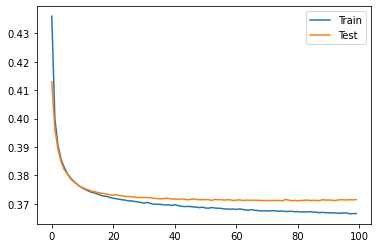

In [9]:
# Train the LSTM
start = datetime.now()
hyperparams = {'numhidunits':100, 'loss':'mae', 
               'optimizer':'adam', 'epochs':100,
               'numhidlayer':1, 'activation':'tanh',
               'isdrop':True, 'dropmag':0.2, 
               'validation_split':0.2}

model, history = fitLSTM(x_train_lstm, y_train_lstm, n_pc, **hyperparams)

print('Training time:',datetime.now()-start)

# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

In [10]:
# plot the LSTM outputs vs the truth
y_tend_lstm = np.zeros((n_train-2, n_pc))

for k in range(n_train-2):
    y_tend_lstm[k,:] = np.squeeze(model.predict(np.expand_dims(x_train_lstm[k,:,:], axis=0), batch_size=1))

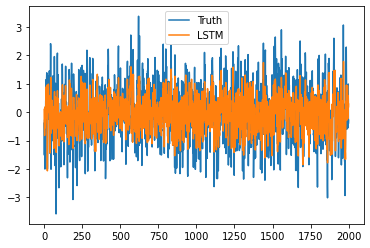

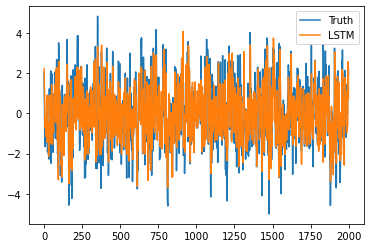

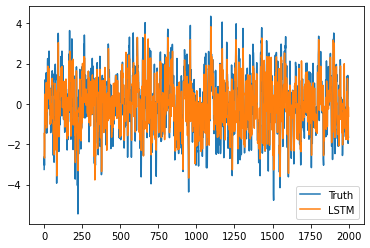

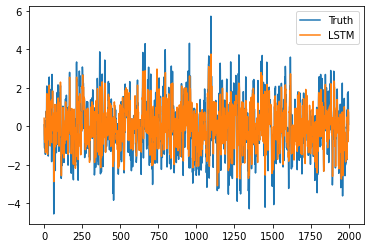

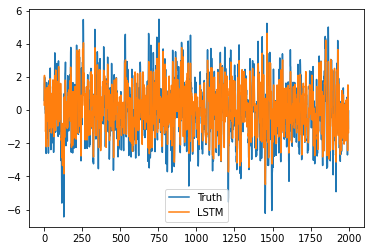

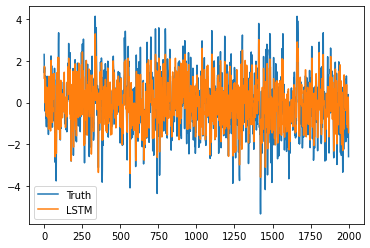

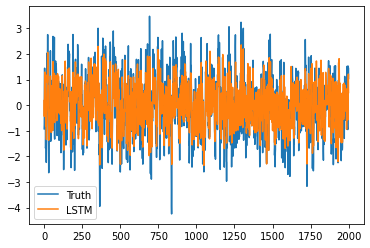

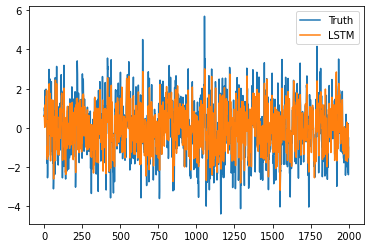

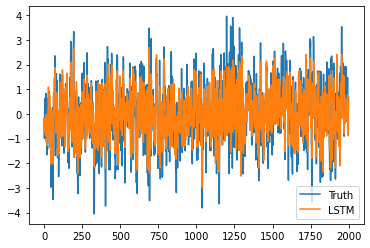

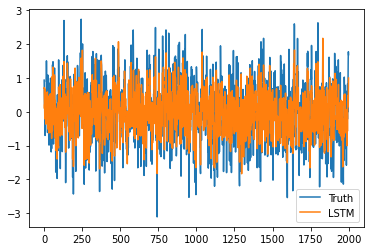

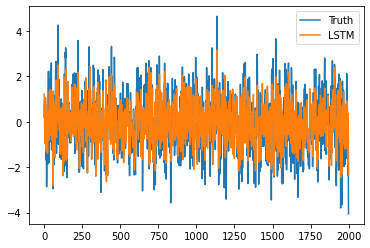

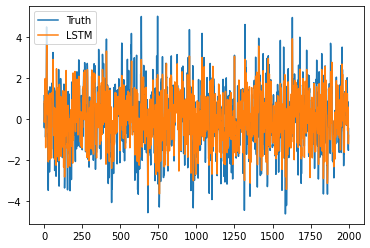

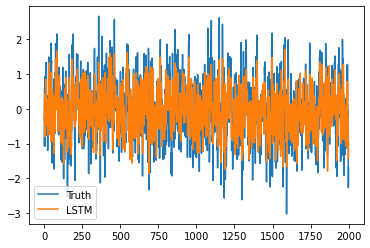

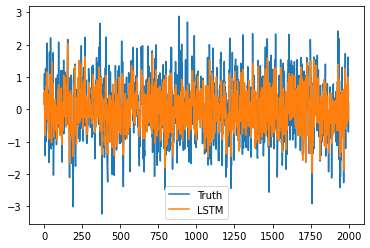

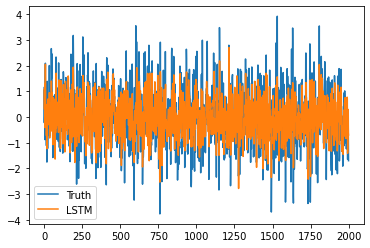

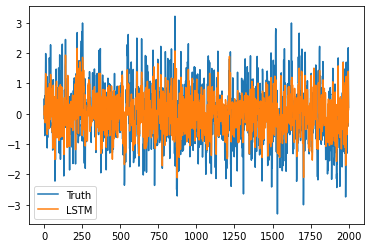

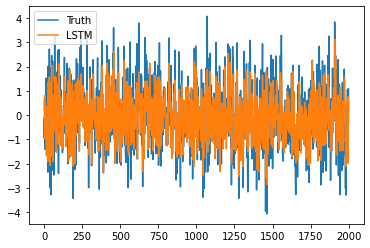

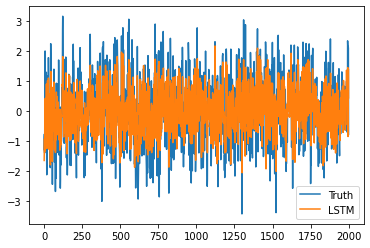

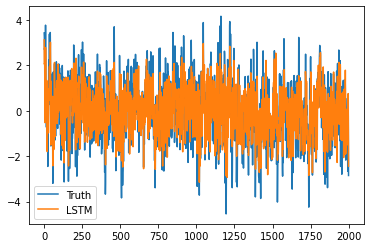

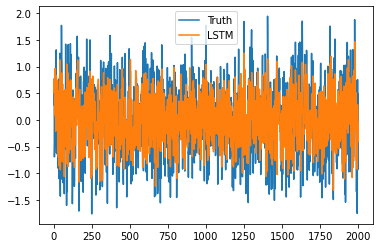

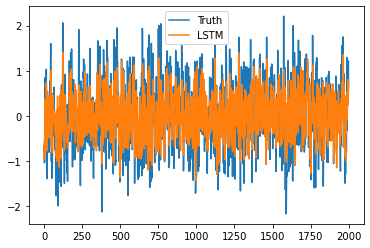

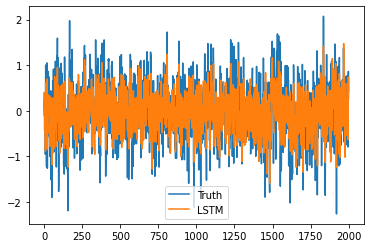

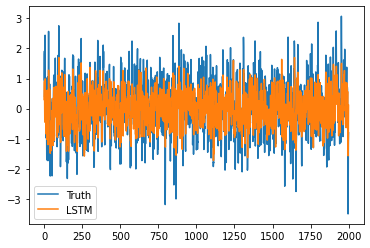

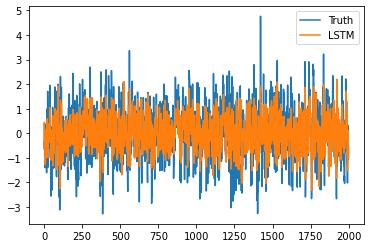

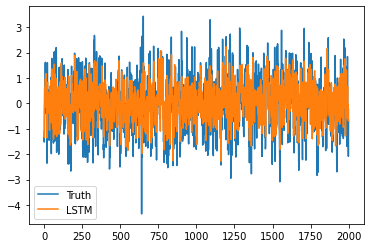

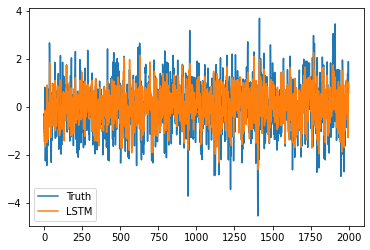

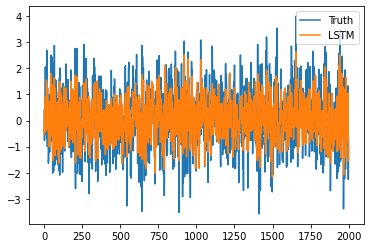

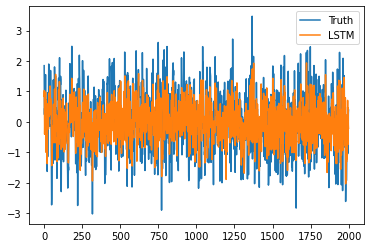

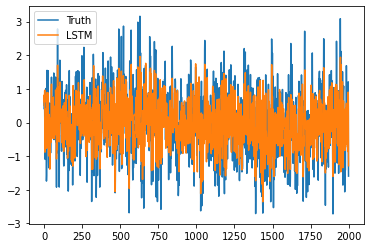

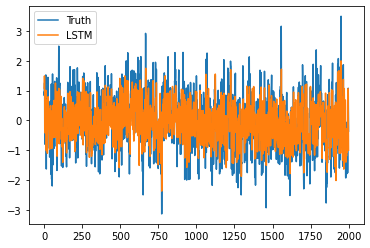

In [11]:
for k in range(30):
    plt.plot(y_train_lstm[:2000,k], label='Truth')
    plt.plot(y_tend_lstm[:2000,k],label='LSTM')
    plt.legend()
    plt.show()

In [12]:
# calculate LSTM residuals
LSTMres = y_train_lstm - y_tend_lstm

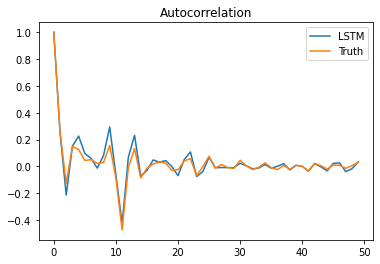

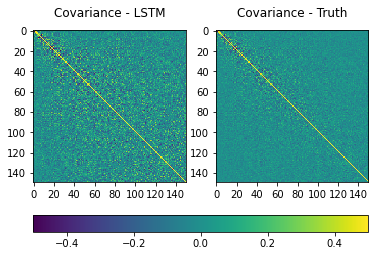

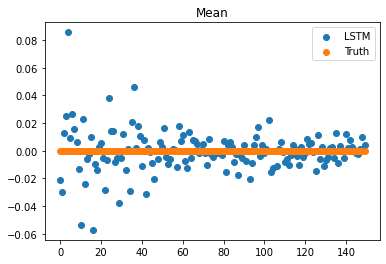

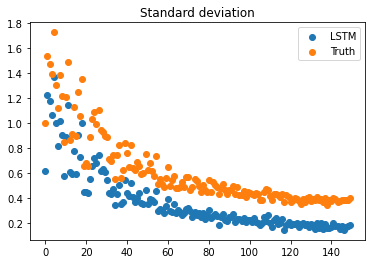

In [13]:
#### LSTM output diagnostics ####
# 1. autocorrelation
n_maxlag = 1000
acorr_lstm = tsaplots.acf(y_tend_lstm[:,-1], nlags=n_maxlag, fft=False)
acorr_truth = tsaplots.acf(y_train_lstm[:,-1], nlags=n_maxlag, fft=False)
plt.plot(acorr_lstm[:50], label='LSTM')
plt.plot(acorr_truth[:50], label='Truth')
plt.title('Autocorrelation')
plt.legend()
plt.show()

# 2. spatial correlation matrix
covn_lstm = np.corrcoef(y_tend_lstm.T) # Correlation coefficients
covn_truth = np.corrcoef(y_train_lstm.T) # Correlation coefficients
fig, (ax1, ax2) = plt.subplots(1,2)
f = ax1.matshow(covn_lstm, vmin=-0.5, vmax=0.5)
ax1.set_title('Covariance - LSTM')
ax1.xaxis.set_ticks_position('bottom')
f = ax2.matshow(covn_truth, vmin=-0.5, vmax=0.5)
ax2.set_title('Covariance - Truth')
ax2.xaxis.set_ticks_position('bottom')
fig.colorbar(f, ax=(ax1,ax2),orientation='horizontal')
plt.show()

# 3. Mean
plt.scatter(range(n_pc),np.mean(y_tend_lstm, axis=0), label='LSTM')
plt.scatter(range(n_pc),np.mean(y_train_lstm, axis=0), label='Truth')
plt.legend()
plt.title('Mean')
plt.show()

# 4. standard deviation
plt.scatter(range(n_pc),np.std(y_tend_lstm, axis=0), label='LSTM')
plt.scatter(range(n_pc),np.std(y_train_lstm, axis=0), label='Truth')
plt.legend()
plt.title('Standard deviation')
plt.show()

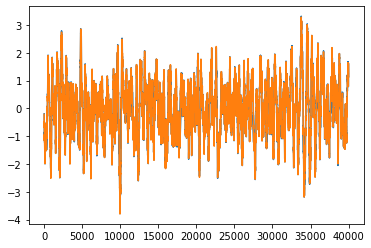

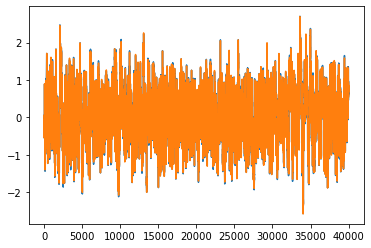

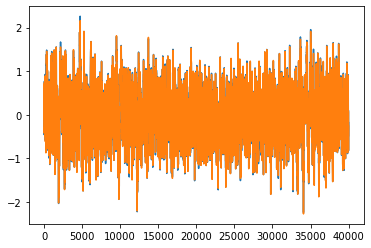

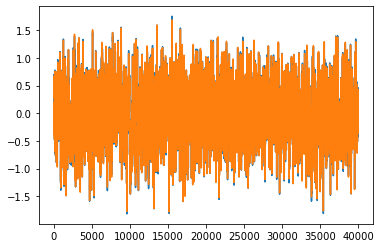

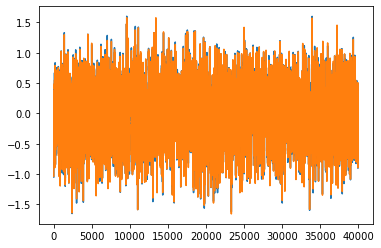

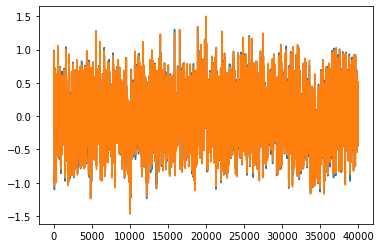

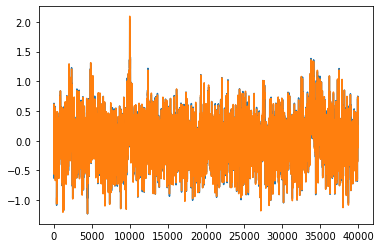

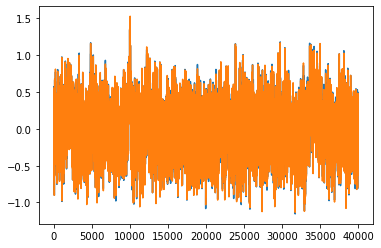

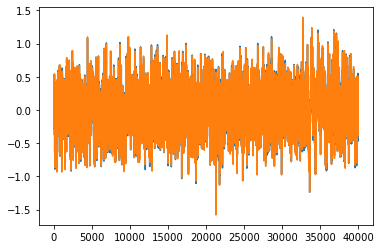

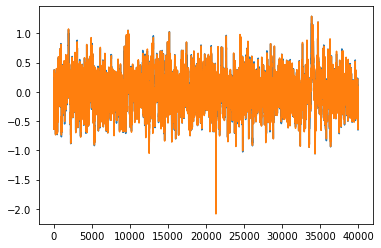

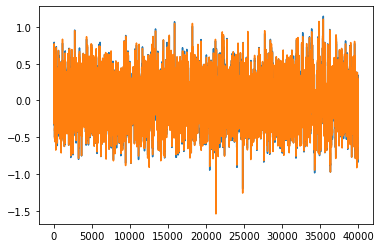

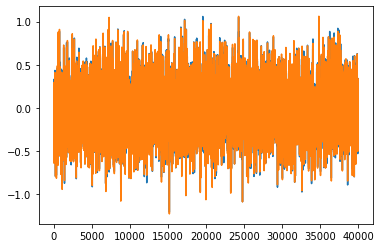

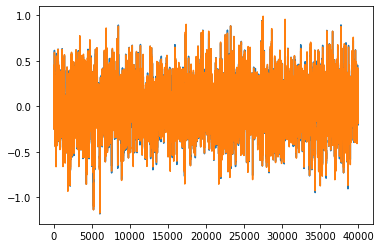

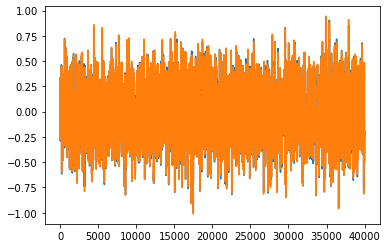

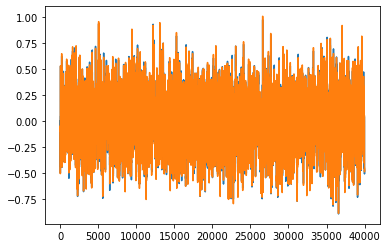

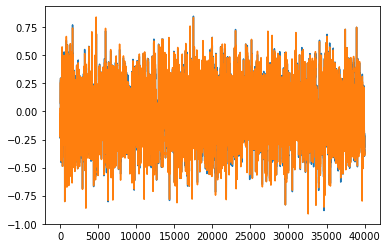

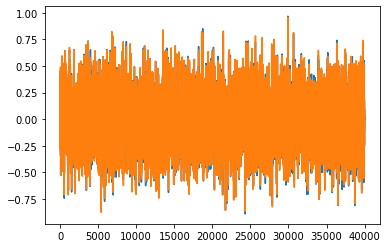

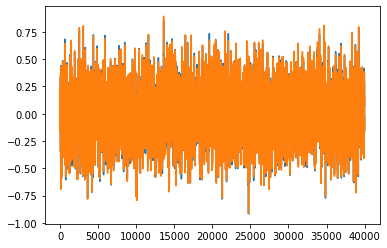

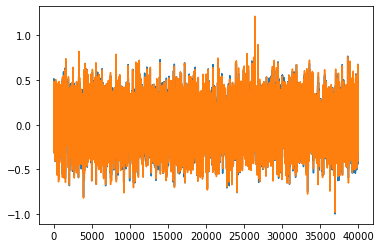

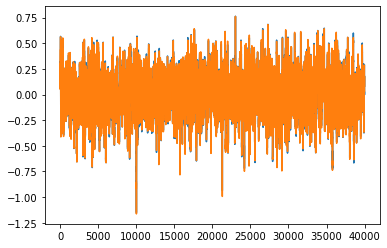

In [14]:
# plot LR+LSTM output for the training data
y_tend_lstm = scaler_linregres.inverse_transform(y_tend_lstm)
y_pred_hybrid = (y_tend_LR[1:,:] + y_tend_lstm)*dt + x_train[1:,:]

for k in range(20):
    plt.plot(y_pred_hybrid[:,k])
    plt.plot(x_train[2:,k])
    plt.show()

In [15]:
# Spatially correlated white noise
def spatialCorrWhtNoise(nt, npc, residual):
    dW = np.random.randn(nt, npc) # additive white noise
    covn = np.corrcoef(residual.T) # Correlation coefficients
    rr = np.linalg.cholesky(covn)
    stdres = np.std(residual, axis=0)
    return dW.dot(rr.T)*stdres

In [13]:
################################################################
################### Short term forecasts #######################
################################################################
n_maxlead = 20  # Prediction of 20 records for each realization
n_ic = int((n_test - n_maxlead - 2))    # Number of initial conditions 
n_ensem = 100
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
isnoise = True
test_dataN = scaler_x.transform(test_data)

start = datetime.now()
for k in range(10):
    # initial conditions
    x_now = test_dataN[k+1:k+2,:]
    x_prev = test_dataN[k:k+1,:]
    res_now = (x_now - x_prev)/dt - linregmodel.predict(x_now)
    res_now = scaler_linregres.transform(res_now)
    
    lstm_icond = np.hstack([x_now, res_now])
    LR_icond = x_now[-1,:].reshape(1,-1)
    
    if isnoise:
        # generate the noise for all ensembles
        dW = spatialCorrWhtNoise(n_ensem*n_maxlead, n_pc, LSTMres)
    else:
        # set zero values to the noise component
        dW = np.zeros((n_ensem*n_maxlead, n_pc))
    
    # produce forecasts
    y_pred[k,:,:,:] = forecast_hybrid(n_maxlead,n_pc,LR_icond,lstm_icond,
                                      dt,model,linregmodel,scaler_x,
                                      scaler_linregres,n_ensem,dW)

enMean_y_pred = np.mean(y_pred, axis=1)
print('Prediction time:', datetime.now()-start)
print('Number of realizations obtained:',n_ic)
print('Prediction length of each realization:',n_maxlead)

Prediction time: 0:00:39.100795
Number of realizations obtained: 9978
Prediction length of each realization: 20


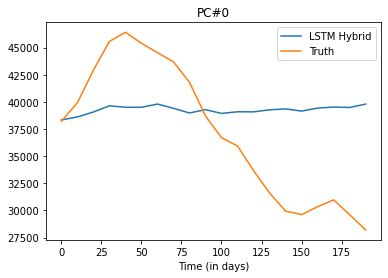

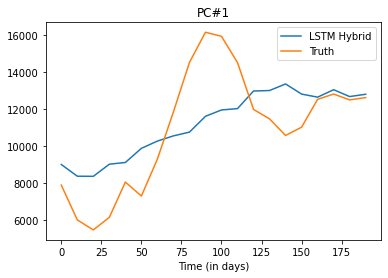

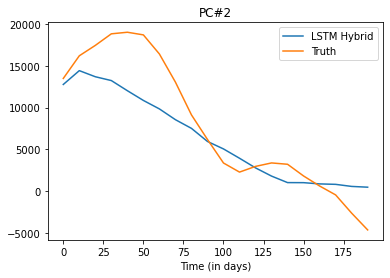

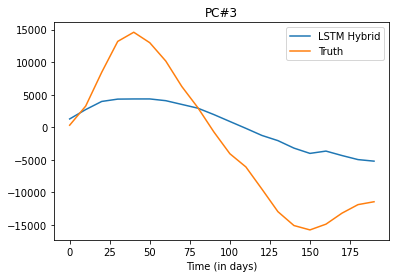

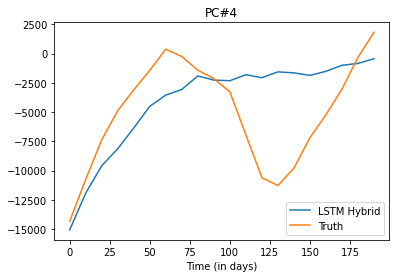

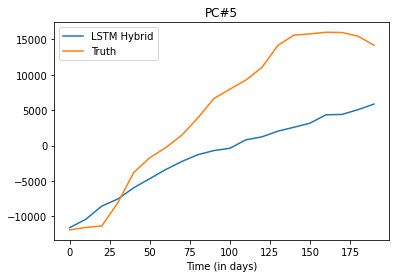

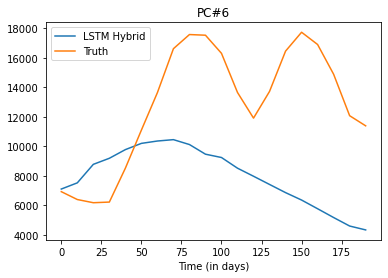

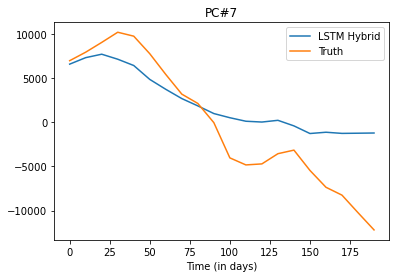

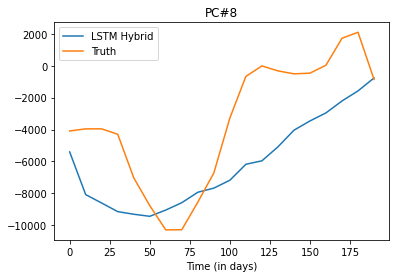

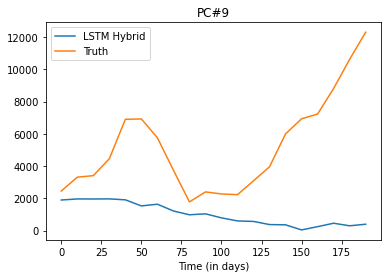

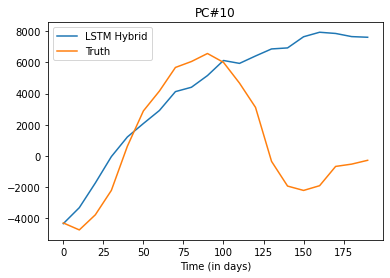

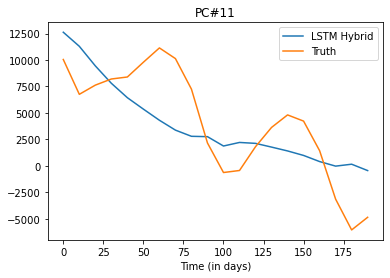

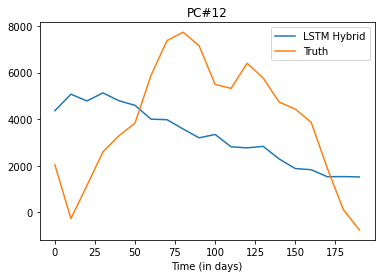

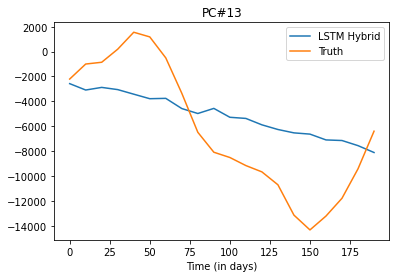

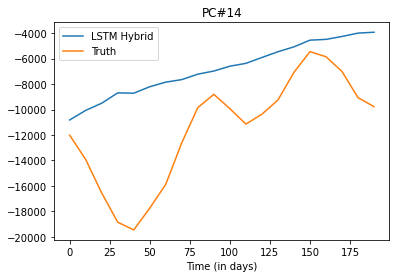

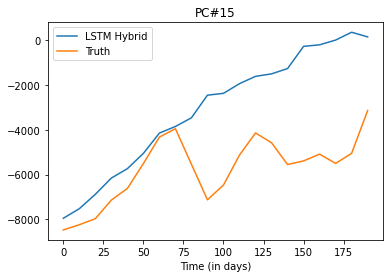

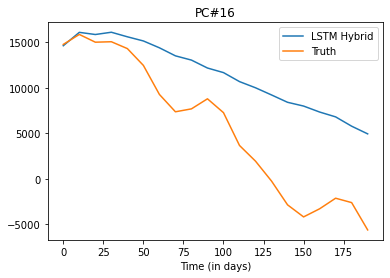

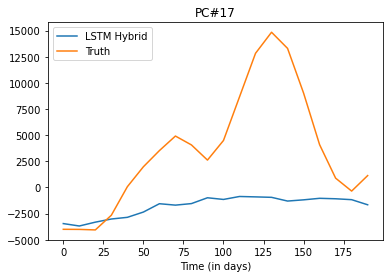

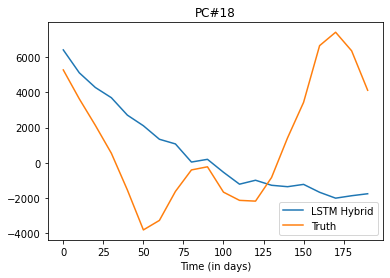

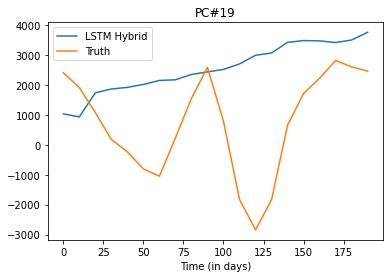

In [17]:
# Plot the predicted results against the truth for any initial condition
ic = 2       # IC index; should be 0,1,2,3..., nic-1 
for k in range(20):
    plt.figure()
    x = np.arange(0,n_maxlead*dt,10)
    plt.plot(x,enMean_y_pred[ic,:,k],label='LSTM Hybrid')
    true_ = test_data[ic+2:ic+n_maxlead+2,k]
    plt.plot(x,true_,label='Truth')
    plt.xlabel('Time (in days)')
    plt.title('PC#'+str(k))
    plt.legend()
    plt.show()

In [21]:
####################################################################
############ Metric 1 : RMSE on the physical space #################
###### Use each data point of the test dataset as an IC ############
## Obtain 100 stochastic realizations (if applicable) for each IC ##
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse = np.zeros((n_ic, n_maxlead))

start = datetime.now()
# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,enMean_y_pred,eofs,n_maxlead) for i in tqdm(range(n_ic)))

meanRMSE = np.mean(rmse, axis=0)
np.save('RMSE_Psi1_200days_predictions_LSTM_hybrid_npc=150_nic=9980_nensem=100_ntrain=400K_ntest=100K',meanRMSE)

100%|██████████| 10/10 [00:00<00:00, 28926.23it/s]


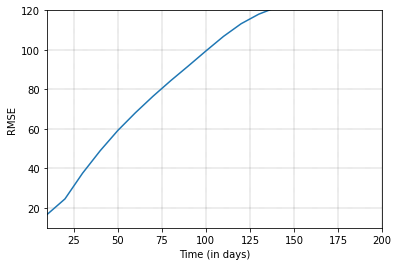

In [22]:
# Plot the mean RMSE
plt.plot(np.arange(dt,n_maxlead*dt+1,dt),meanRMSE)
plt.xlabel('Time (in days)')
plt.ylabel('RMSE')
plt.ylim([10, 120])
plt.xlim([dt, n_maxlead*dt])
plt.grid(color='k', linestyle='--', linewidth=0.2)
plt.savefig('RMSE_Psi1_200days_predictions_LSTM_hybrid_npc=150_nic=9980_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

In [23]:
####################################################################
# Metric 2a : Instantaneous temporal correlation coefficient (ITCC) #
####################################################################
itcc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    itcc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'temporal') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meanitcc = np.mean(itcc, axis=0)

100%|██████████| 10/10 [00:00<00:00, 33314.57it/s]


Time taken: 0:00:01.720091


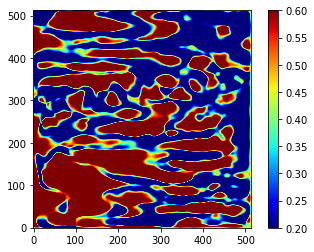

In [24]:
plt.imshow(meanitcc.reshape(nx,ny), origin='lower',cmap='jet')
plt.colorbar()
plt.clim([0.2, 0.6])
plt.savefig('ITCC_Psi1_200days_predictions_LSTM_hybrid_npc=150_nic=9980_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('ITCC_Psi1_200days_predictions_LSTM_hybrid_npc=150_nic=9980_ntrain=400K_ntest=100K',meanitcc)

In [25]:
####################################################################
# Metric 2b : Instantaneous spatial correlation coefficient (ISCC) #
####################################################################
iscc = np.zeros((n_ic, n_maxlead))

start = datetime.now()
if __name__ == "__main__":
    iscc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'spatial') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meaniscc = np.mean(iscc, axis=0)

100%|██████████| 10/10 [00:00<00:00, 38374.24it/s]


Time taken: 0:00:01.581028


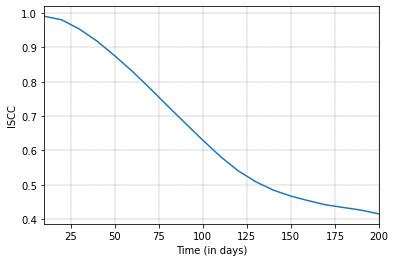

In [26]:
plt.plot(np.arange(dt,n_maxlead*dt+1,dt), meaniscc)
plt.xlabel('Time (in days)')
plt.ylabel('ISCC')
plt.xlim([dt, n_maxlead*dt])
plt.grid(color='k', linestyle='--', linewidth=0.2)
plt.savefig('ISCC_Psi1_200days_predictions_LSTM_hybrid_npc=150_nic=9980_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('ISCC_Psi1_200days_predictions_LSTM_hybrid_npc=150_nic=9980_ntrain=400K_ntest=100K',meaniscc)

In [27]:
################################################################
############### Long term forecasts: 10,000 days ###############
################################################################
n_ic = 1    # Number of initial conditions   
n_maxlead = 1000  # Prediction of 1000 records for each realization
n_ensem = 1
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
isnoise = True
test_dataN = scaler_x.transform(test_data)

for k in range(n_ic):
    
    # initial conditions
    x_now = test_dataN[k+1:k+2,:]
    x_prev = test_dataN[k:k+1,:]
    res_now = (x_now - x_prev)/dt - linregmodel.predict(x_now)
    res_now = scaler_linregres.transform(res_now)
    
    lstm_icond = np.hstack([x_now, res_now])
    LR_icond = x_now[-1,:].reshape(1,-1)
    
    start = datetime.now()
    if isnoise:
        # generate the noise for all ensembles
        dW = spatialCorrWhtNoise(n_ensem*n_maxlead, n_pc, LSTMres)
    else:
        # set zero values to the noise component
        dW = np.zeros((n_ensem*n_maxlead, n_pc))
    print('Noise generation time:',datetime.now()-start)
    
    start = datetime.now()
    # produce forecasts
    y_pred[k,:,:,:] = forecast_hybrid(n_maxlead,n_pc,LR_icond,lstm_icond,
                                      dt,model,linregmodel,scaler_x,
                                      scaler_linregres,n_ensem,dW)
    print('Prediction time:', datetime.now()-start)

enMean_y_pred = np.mean(y_pred, axis=1)
print('Number of realizations obtained:',n_ic)
print('Prediction length of each realization:',n_maxlead)

Noise generation time: 0:00:00.123580
Prediction time: 0:00:01.799807
Number of realizations obtained: 1
Prediction length of each realization: 1000


In [28]:
###### Time complexity ######
# Pure LR+LSTM hybrid
# Training time = LR training (0.6sec) + LSTM training (~600sec for 100 epochs)
# Prediction time = time to produce one 10K days realization using one initial condition(2 sec)
#
# LR + LSTM + Noise hybrid
# Training time = LR training (0.6sec) + LSTM training (~600sec for 100 epochs) + time to calculate the standard deviations of LR+LSTM residuals (0.2sec)
# Prediction time = time to produce one 10K days realization using one initial condition(2sec)+ noise generation time (0.1sec)

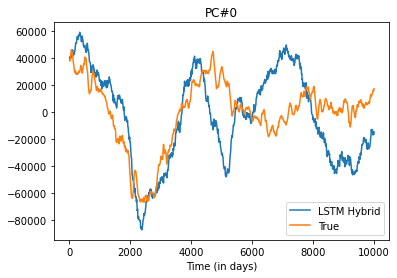

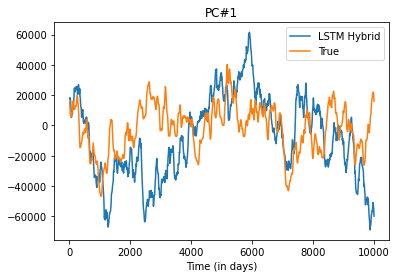

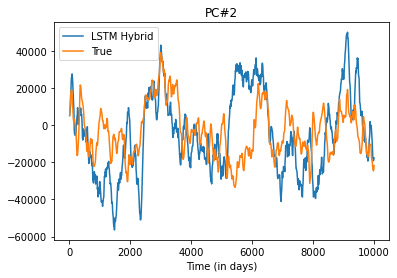

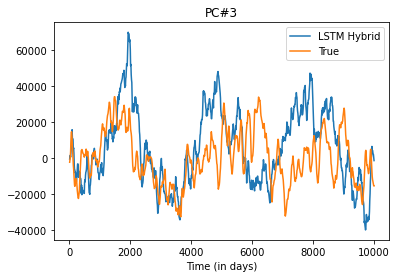

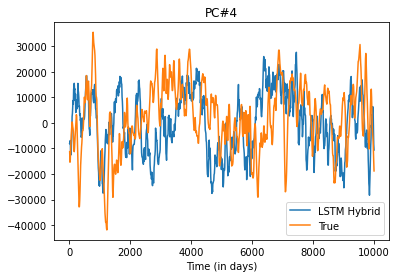

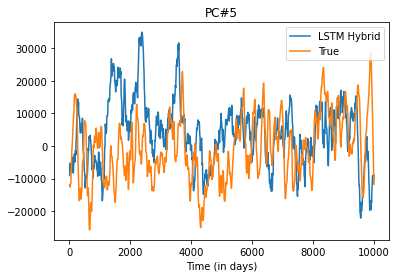

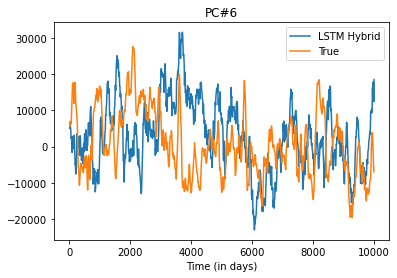

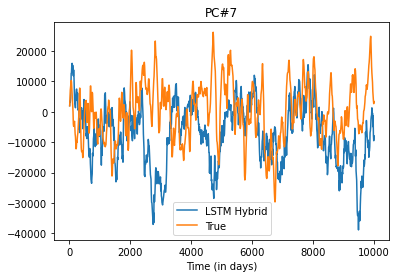

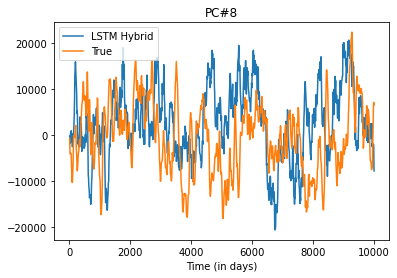

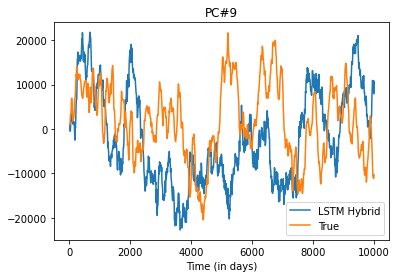

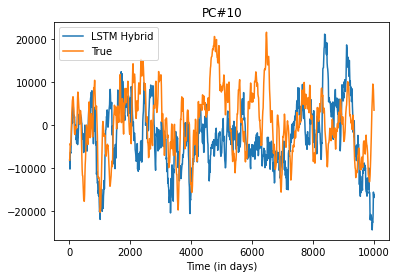

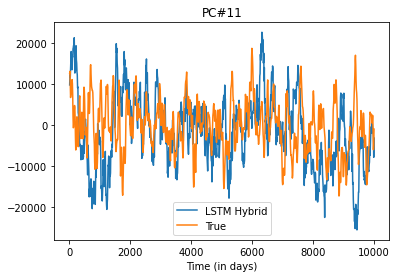

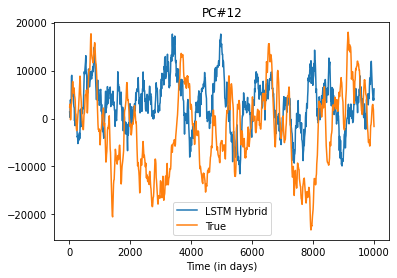

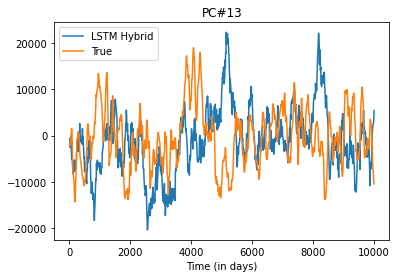

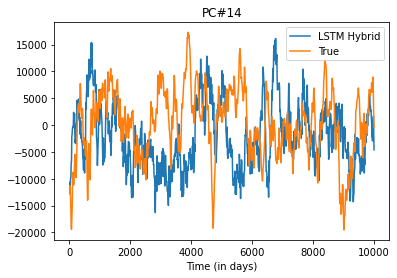

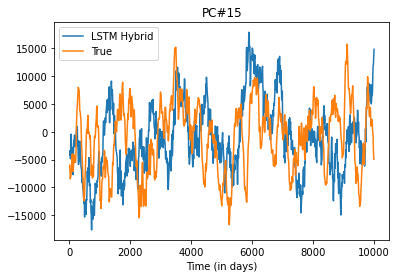

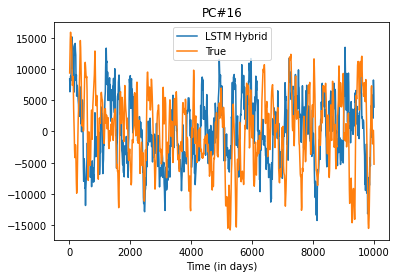

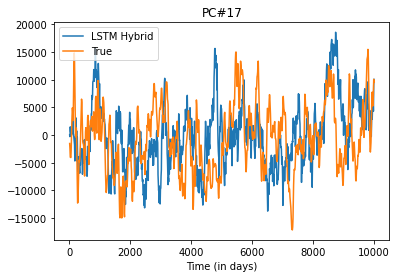

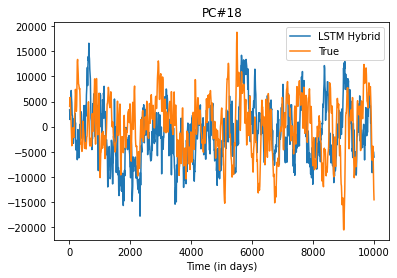

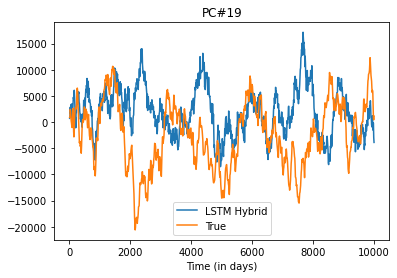

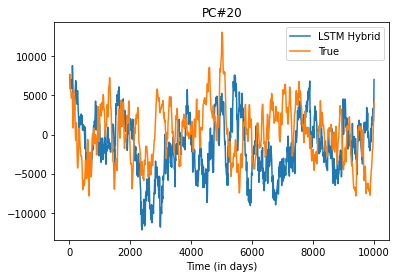

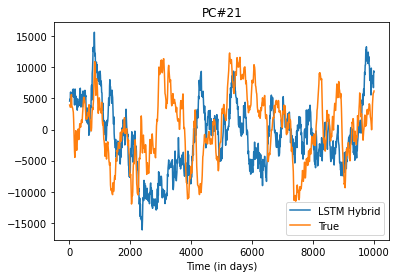

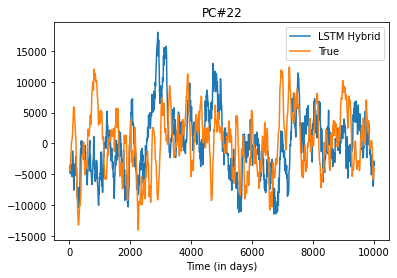

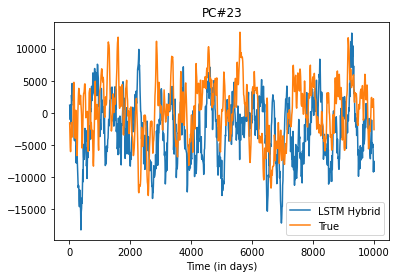

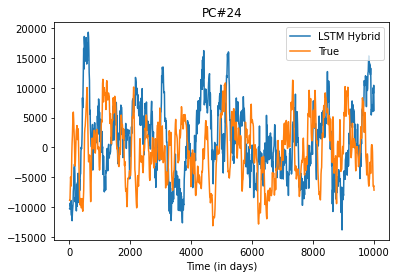

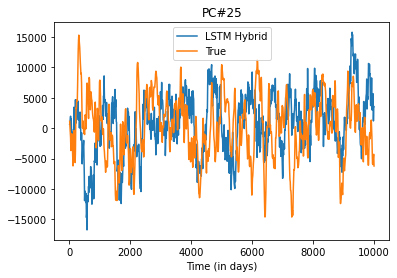

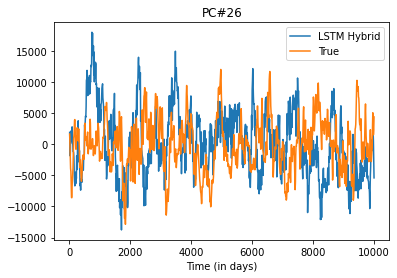

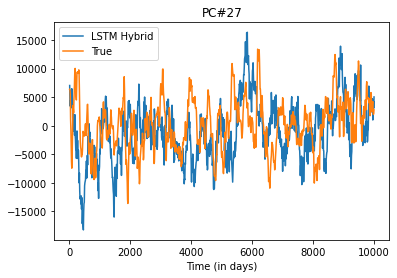

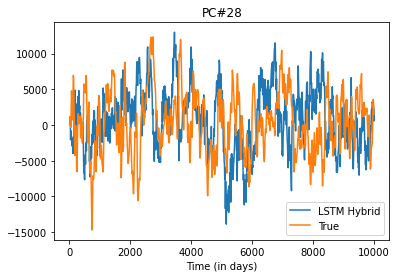

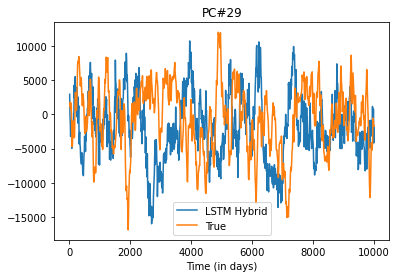

In [29]:
#############################################################
####### Plot the predicted results against the truth ########
#############################################################
ic = 0       # Should be 0,1,2,3...,nic-1
for k in range(0,30):
    plt.figure()
    x = np.arange(dt,n_maxlead*dt+1,dt)
    plt.plot(x, enMean_y_pred[ic,:,k],label='LSTM Hybrid')
    plt.plot(x, test_data[ic+2:ic+2+n_maxlead,k],label='True')
    plt.title('PC#' + str(k+1))
    plt.xlabel('Time (in days)')
    plt.title('PC#'+str(k))
    plt.legend()
    plt.show()

In [31]:
################################################################
############# Metric 3 : Climatology and Variance ##############
######### using multiple realizations of 10,000 days  #########
################################################################
psi1_climatology_pred = np.zeros((n_ic,nx*ny))
psi1_variance_pred = np.zeros((n_ic,nx*ny))

# Project the modelled PCs onto the EOFs and calculate climatology
for kk in range(n_ic):
    psi1_pred = enMean_y_pred[kk,:,:].dot(eofs)
    psi1_climatology_pred[kk,:] = np.mean(psi1_pred, axis=0)
    psi1_variance_pred[kk,:] = np.var(psi1_pred, axis=0)

mean_psi1_climatology_pred = np.mean(psi1_climatology_pred, axis=0)
mean_psi1_variance_pred = np.mean(psi1_variance_pred, axis=0)

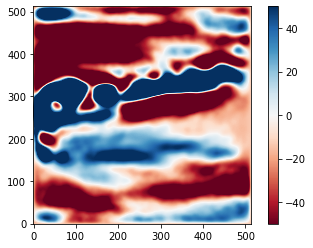

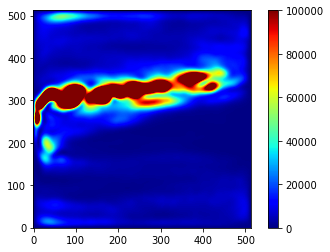

In [32]:
# Climatology and variance of the predictions
plt.imshow(mean_psi1_climatology_pred.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.clim(-50, 50)
plt.colorbar()
plt.savefig('Climatology_Psi1_10Kdays_predictions_LSTM_hybrid_npc=150_nic=1_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

plt.imshow(mean_psi1_variance_pred.reshape(nx,ny), origin='lower', cmap='jet')
plt.clim(0, 100000)
plt.colorbar()
plt.savefig('Variance_Psi1_10Kdays_predictions_LSTM_hybrid_npc=150_nic=1_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

In [ ]:
##################################################
############# Metric 4: Frequency map ############
####### frequency = 1/decorrelation time #########
##################################################
freq_pred = np.zeros((n_ic,nx*ny))

for kk in range(n_ic):
    psi1_pred = enMean_y_pred[kk,:,:].dot(eofs)
    start = datetime.now()
    if __name__ == "__main__":
        freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_pred,dt) for i in tqdm(range(nx*ny)))
    freq_pred[kk,:] = freq_
    print('Time taken:',datetime.now()-start)
    
# mean frequency
mean_freq_pred = np.mean(freq_pred, axis=0)

In [ ]:
plt.imshow(np.array(mean_freq_pred).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0,4])
plt.savefig('Frequency_Psi1_10Kdays_predictions_LSTM_hybrid_npc=150_nic=1_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()